<a href="https://colab.research.google.com/github/dani-lbnl/mudit/blob/main/notebooks/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize 
import numpy as np
import pandas as pd

import seaborn as sns

import torch
import torch.nn as nn
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# setup drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_table('drive/MyDrive/LBNL/Pubs.xls')
abstracts = list(df[~df['Abstract'].isna()]['Abstract'])

In [15]:
indices = df[df['Title'].isna()].index
# indices
df.drop(indices, inplace=True)

In [17]:
indices = df.loc[pd.isna(df["Abstract"]), :].index
# indices
df.drop(indices, inplace=True)

In [18]:
indices = df['Research Area'].isna()
df.loc[indices,'Research Area'] = "Unknown"

none_ind = (df['Research Area'] == "None")
df.loc[none_ind,'Research Area'] = "Unknown"

In [19]:
df['Combined'] = df['Title'] + " " + df['Abstract']

In [20]:
indices = df['Research Area'].isin(['Applied Science / techniques','Applied Science - techniques','Applied science - techniques'])
df.loc[indices,'Research Area'] = 'Applied Science - techniques'

In [21]:
df['Research Area'].unique()

array(['Unknown', 'Bioscience', 'Geoscience - Environment',
       'Applied Science - techniques', 'Materials - Condensed matter',
       'Energy Science', 'Physics', 'Chemistry'], dtype=object)

In [22]:
df.groupby('Research Area')['Research Area'].count()

Research Area
Applied Science - techniques    29
Bioscience                      71
Chemistry                        1
Energy Science                  42
Geoscience - Environment        58
Materials - Condensed matter    45
Physics                          3
Unknown                          8
Name: Research Area, dtype: int64

# 1. mat2vec embedding & k-means

In [25]:
df['Combined']

1      Effect of aging on the toughness of human cort...
2      Age related transparent Root Dentin: Mineral C...
5      An Orientation Distribution function for trabe...
6      Sequential treatment of overiectomized mice wi...
8      Permeability of anisotropic tube pumice: Model...
                             ...                        
434    Breadcrust bubbles: Ash particles recording po...
435    Toughening mechanisms of the elytra of the dia...
437    Scalable method for micro-CT analysis enables ...
438    Scaleup and manufacturability of symmetric-str...
439    Natural selection maintains species despite fr...
Name: Combined, Length: 257, dtype: object

In [26]:
def preprocess_text(text):    
  stop_words = set(stopwords.words('english'))  
  word_tokens = word_tokenize(text)  
  words = [w.lower() for w in word_tokens if not w.lower() in stop_words and w.lower().isalpha()]
  return words

df['combined_cleaned'] = df['Combined'].apply(preprocess_text)

In [ ]:
model = Word2Vec.load("word2vec_embeddings-SNAPSHOT.model")

In [ ]:
def read_mat_data(input, vocab, embs):
    data=[]
    
    for line in input:
      avg_counter = 0
      avg_emb=np.zeros(100)
      words = []
      for word in line:
        word=word.lower()
        if word in vocab:
            words.append(word)
            avg_emb += model[word]
            avg_counter += 1.
      avg_emb /= avg_counter
      if(avg_counter > 0):
        data.append(avg_emb)
      print(avg_counter, words)
    return data 

In [ ]:
embeddings = read_mat_data(df['combined_cleaned'],model.wv.vocab,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


104.0 ['effect', 'aging', 'toughness', 'human', 'cortical', 'bone', 'evaluation', 'deterioration', 'fracture', 'properties', 'bone', 'coupled', 'increased', 'life', 'expectancy', 'responsible', 'increasing', 'incidence', 'bone', 'fracture', 'elderly', 'hence', 'understanding', 'fracture', 'properties', 'degrade', 'age', 'essential', 'present', 'study', 'describes', 'ex', 'vivo', 'fracture', 'experiments', 'quantitatively', 'assess', 'effect', 'aging', 'fracture', 'toughness', 'properties', 'human', 'cortical', 'bone', 'longitudinal', 'direction', 'cortical', 'bone', 'exhibits', 'rising', 'resistance', 'crack', 'extension', 'unlike', 'previous', 'studies', 'toughness', 'evaluated', 'terms', 'behavior', 'measured', 'bone', 'taken', 'wide', 'range', 'age', 'groups', 'years', 'using', 'approach', 'ex', 'vivo', 'toughness', 'determined', 'found', 'deteriorate', 'age', 'initiation', 'toughness', 'decreases', 'decades', 'years', 'growth', 'toughness', 'effectively', 'eliminated', 'age', 'rang

In [ ]:
n = 7
kmeans = KMeans(n_clusters=n, random_state=0).fit(np.array(embeddings))
kmeans.labels_

arr = [[0]] * n
for i in range(n):
  ind = (kmeans.labels_ == i)
  print(i)
  # print(list(df.iloc[ind]['Research Area']))
  indices = [i for i, x in enumerate(ind) if x]
  vals = []
  for j in list(set(df['Research Area'])):
    s = (df.iloc[indices]['Research Area'] == j).sum()
    vals.append(round(s/(df['Research Area']==j).sum(),2))

  arr[i] = vals

arr

0
1
2
3
4
5
6


[[0.03, 0.0, 0.09, 0.0, 0.05, 0.25, 0.67, 0.0],
 [0.07, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.46],
 [0.14, 0.33, 0.29, 1.0, 0.48, 0.12, 0.24, 0.01],
 [0.31, 0.33, 0.38, 0.0, 0.16, 0.12, 0.07, 0.06],
 [0.0, 0.0, 0.22, 0.0, 0.0, 0.5, 0.0, 0.35],
 [0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.03],
 [0.45, 0.33, 0.02, 0.0, 0.05, 0.0, 0.02, 0.08]]

In [ ]:
kmeans_df = pd.DataFrame(arr)
kmeans_df.columns = list(set(df['Research Area']))
kmeans_df

,Applied Science - techniques,Physics,Materials - Condensed matter,Chemistry,Geoscience - Environment,Unknown,Energy Science,Bioscience
0,0.03,0.00,0.09,0.0,0.05,0.25,0.67,0.00
1,0.07,0.00,0.00,0.0,0.02,0.00,0.00,0.46
2,0.14,0.33,0.29,1.0,0.48,0.12,0.24,0.01
3,0.31,0.33,0.38,0.0,0.16,0.12,0.07,0.06
4,0.00,0.00,0.22,0.0,0.00,0.50,0.00,0.35
5,0.00,0.00,0.00,0.0,0.24,0.00,0.00,0.03
6,0.45,0.33,0.02,0.0,0.05,0.00,0.02,0.08


In [ ]:
pca = PCA(n_components=10)
comps = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)
first_comp = comps[:,0]
second_comp = comps[:,1]

[0.13389103 0.12171427 0.09659107 0.0699092  0.04327305 0.03960226
 0.03544787 0.03327217 0.02729987 0.02325346]


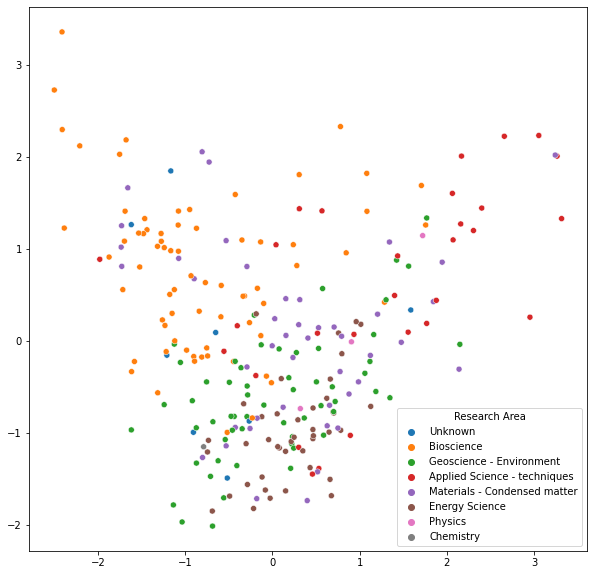

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=first_comp, y=second_comp, hue=df['Research Area'], ax=ax)

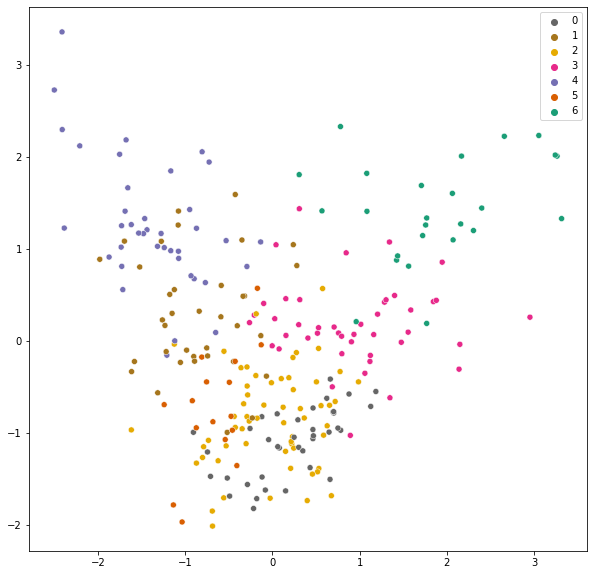

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=first_comp, y=second_comp, hue=kmeans.labels_, palette='Dark2_r', ax=ax)

# 2. TF-IDF weighted mat2vec embeddings

In [ ]:
import nltk
import string
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(item.lower())
        # stems.append(PorterStemmer().stem(item))
    return stems

for text in df['Combined']:
  token_dict[text] = text.lower().translate(str.maketrans('','',string.punctuation))

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())

In [ ]:
def read_mat_data(input, vocab, embs):
    data=[]
    
    for line in input:
      # print(line)
      response = tfidf.transform([line])
      feature_names = tfidf.get_feature_names()
      avg_counter = 0
      avg_emb=np.zeros(100)
      for col in response.nonzero()[1]:
          name = feature_names[col]
          val = response[0, col]
          # print(feature_names[col], ' - ', response[0, col])
          if name in vocab:
            avg_emb += val * model[name]
            avg_counter += 1.
      
      if(avg_counter > 0):
        avg_emb /= avg_counter
        data.append(avg_emb)
      print(avg_counter)
    return data 

In [ ]:
embeddings = read_mat_data(df['Combined'],model.wv.vocab,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

74.0
77.0
76.0
103.0
66.0
77.0
64.0
83.0
101.0
90.0
86.0
109.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

84.0
94.0
76.0
120.0
36.0
92.0
65.0
92.0
98.0
63.0
91.0
76.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

66.0
71.0
89.0
64.0
70.0
84.0
98.0
77.0
141.0
70.0
80.0
86.0
101.0
126.0
79.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

112.0
83.0
85.0
78.0
51.0
79.0
64.0
68.0
88.0
87.0
155.0
101.0
89.0
102.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

72.0
101.0
67.0
66.0
76.0
83.0
90.0
76.0
64.0
124.0
112.0
84.0
59.0
86.0
98.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

137.0
83.0
97.0
106.0
110.0
117.0
125.0
60.0
95.0
76.0
90.0
100.0
191.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

104.0
135.0
133.0
82.0
77.0
82.0
116.0
90.0
54.0
72.0
100.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

82.0
78.0
147.0
69.0
97.0
90.0
53.0
57.0
94.0
93.0
49.0
46.0
73.0
81.0
90.0
81.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

58.0
119.0
122.0
77.0
104.0
95.0
76.0
98.0
35.0
73.0
44.0
56.0
47.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:


84.0
83.0
81.0
87.0
79.0
59.0
113.0
24.0
29.0
25.0
105.0
104.0
25.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

26.0
24.0
77.0
60.0
26.0
25.0
17.0
18.0
140.0
79.0
22.0
22.0
84.0
127.0
99.0
88.0
92.0
101.0
104.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

154.0
66.0
77.0
70.0
80.0
85.0
40.0
175.0
58.0
119.0
79.0
49.0
87.0
64.0
74.0
83.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

91.0
89.0
80.0
93.0
54.0
62.0
103.0
75.0
66.0
62.0
109.0
84.0
96.0
77.0
100.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

60.0
108.0
108.0
93.0
103.0
76.0
85.0
54.0
197.0
73.0
88.0
77.0
93.0
119.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

54.0
57.0
116.0
103.0
111.0
86.0
74.0
79.0
32.0
59.0
97.0
77.0
87.0
52.0
109.0
67.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

82.0
96.0
77.0
105.0
167.0
87.0
70.0
106.0
68.0
75.0
68.0
95.0
91.0
79.0
56.0
74.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

116.0
69.0
99.0
77.0
76.0
100.0
71.0
77.0
96.0
73.0
101.0
102.0
84.0
75.0
121.0
90.0
91.0
122.0
101.0
87.0
106.0
116.0
67.0
104.0
69.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

73.0
69.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [ ]:
n = 7
kmeans = KMeans(n_clusters=n, random_state=0).fit(np.array(embeddings))
kmeans.labels_

arr = [[0]] * n
for i in range(n):
  ind = (kmeans.labels_ == i)
  print(i)
  indices = [i for i, x in enumerate(ind) if x]
  vals = []
  for j in list(set(df['Research Area'])):
    s = (df.iloc[indices]['Research Area'] == j).sum()
    vals.append(round(s/(df['Research Area']==j).sum(),2))

  arr[i] = vals

arr

0
1
2
3
4
5
6


[[0.0, 0.0, 0.02, 0.0, 0.41, 0.0, 0.1, 0.41],
 [0.52, 0.33, 0.04, 0.0, 0.07, 0.0, 0.0, 0.07],
 [0.03, 0.0, 0.0, 1.0, 0.02, 0.0, 0.0, 0.0],
 [0.07, 0.0, 0.16, 0.0, 0.0, 0.25, 0.0, 0.45],
 [0.31, 0.67, 0.51, 0.0, 0.45, 0.38, 0.24, 0.04],
 [0.03, 0.0, 0.27, 0.0, 0.05, 0.38, 0.67, 0.0],
 [0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03]]

In [ ]:
kmeans_df = pd.DataFrame(arr)
kmeans_df.columns = list(set(df['Research Area']))
kmeans_df

,Applied Science - techniques,Physics,Materials - Condensed matter,Chemistry,Geoscience - Environment,Unknown,Energy Science,Bioscience
0,0.00,0.00,0.02,0.0,0.41,0.00,0.10,0.41
1,0.52,0.33,0.04,0.0,0.07,0.00,0.00,0.07
2,0.03,0.00,0.00,1.0,0.02,0.00,0.00,0.00
3,0.07,0.00,0.16,0.0,0.00,0.25,0.00,0.45
4,0.31,0.67,0.51,0.0,0.45,0.38,0.24,0.04
5,0.03,0.00,0.27,0.0,0.05,0.38,0.67,0.00
6,0.03,0.00,0.00,0.0,0.00,0.00,0.00,0.03


In [ ]:
pca = PCA(n_components=10)
comps = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)
first_comp = comps[:,0]
second_comp = comps[:,1]

[0.15561891 0.125187   0.08322479 0.06381639 0.0536086  0.03703769
 0.03655772 0.0305013  0.02934912 0.02433469]


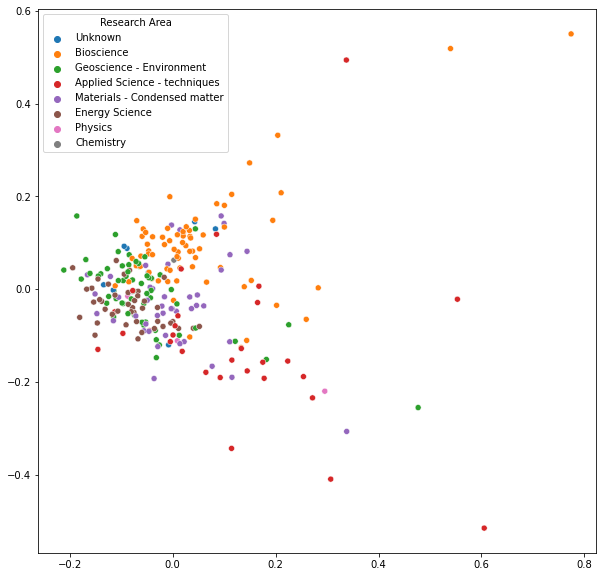

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=first_comp, y=second_comp, hue=df['Research Area'], ax=ax)

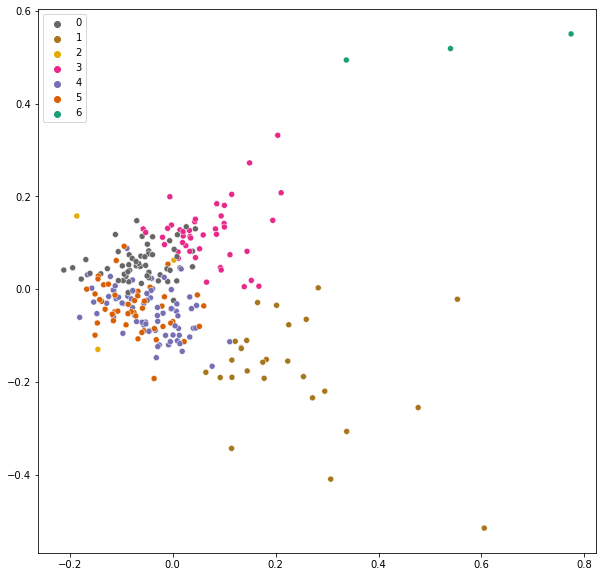

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=first_comp, y=second_comp, hue=kmeans.labels_, palette='Dark2_r', ax=ax)

In [ ]:
np.save('embeddings.npy',embeddings)

Combined KNN

In [ ]:
#Word2vec

size = 200
model1 = Word2Vec(df['Cleaned'], min_count = 1,  size = size) 
# embeddings = read_glove_data(df['Cleaned'],model1.wv.vocab,model1, size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([model['NiWO4'],model['bubbles']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1.        , 0.18914835],
       [0.18914835, 0.99999994]], dtype=float32)